In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lending-club/rejected_2007_to_2018Q4.csv.gz
/kaggle/input/lending-club/accepted_2007_to_2018Q4.csv.gz
/kaggle/input/lending-club/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv
/kaggle/input/lending-club/rejected_2007_to_2018q4.csv/rejected_2007_to_2018Q4.csv


In [2]:
import pandas as pd

path = "/kaggle/input/lending-club/rejected_2007_to_2018Q4.csv.gz"

df_rejected = pd.read_csv(path, low_memory=False, nrows=500_000)  # sample for quicker EDA
df_rejected.head()
df_rejected.columns

Index(['Amount Requested', 'Application Date', 'Loan Title', 'Risk_Score',
       'Debt-To-Income Ratio', 'Zip Code', 'State', 'Employment Length',
       'Policy Code'],
      dtype='object')

In [2]:
import pandas as pd

path = "/kaggle/input/lending-club/accepted_2007_to_2018Q4.csv.gz"

df_accepted = pd.read_csv(path, low_memory=False, nrows=500_000)  # sample for quicker EDA
df_accepted.head()


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
print(df_accepted.columns)

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'disbursement_method', 'debt_settlement_flag',
       'debt_settlement_flag_date', 'settlement_status', 'settlement_date',
       'settlement_amount', 'settlement_percentage', 'settlement_term'],
      dtype='object', length=151)


In [5]:
df_accepted.isna().sum()

id                            0
member_id                500000
loan_amnt                     2
funded_amnt                   2
funded_amnt_inv               2
                          ...  
settlement_status        488251
settlement_date          488251
settlement_amount        488251
settlement_percentage    488251
settlement_term          488251
Length: 151, dtype: int64

### task 2: multilayer perceptron

In [97]:
# loan_mlp_training.py
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score, f1_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# -------------------------------
# 1️⃣ Settings
# -------------------------------
RANDOM_SEED = 42
BATCH_SIZE = 1024
NUM_EPOCHS = 20
LR = 1e-3

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# -------------------------------
# 2️⃣ Load dataset
# -------------------------------
# Replace this with your dataset
# df = pd.read_csv("loan_data.csv")
df = df_accepted  # Assuming your preloaded DataFrame

# -------------------------------
# 3️⃣ Feature selection
# -------------------------------
final_features = [
    'loan_amnt','int_rate','term_months','annual_inc','dti',
    'emp_length_yrs','grade','home_ownership','purpose',
    'verification_status','application_type','revol_util',
    'open_acc','total_acc','delinq_2yrs','inq_last_6mths',
    'pub_rec','credit_age_years'
]

df_selected = df[final_features + ['target']].copy()

# -------------------------------
# 4️⃣ Downsample majority class
# -------------------------------
majority = df_selected[df_selected["target"] == 0]
minority = df_selected[df_selected["target"] == 1]

majority_downsampled = resample(
    majority, replace=False, n_samples=len(minority), random_state=RANDOM_SEED
)

df_bal = pd.concat([majority_downsampled, minority]).reset_index(drop=True)
print("[Debug] Balanced class counts:\n", df_bal['target'].value_counts())

# -------------------------------
# 5️⃣ Preprocess features
# -------------------------------
categorical_cols = df_bal.select_dtypes(include=['object']).columns.tolist()
numerical_cols = [c for c in final_features if c not in categorical_cols]

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_cols),
    ('cat', cat_pipeline, categorical_cols)
])

X = preprocessor.fit_transform(df_bal[final_features]).astype(np.float32)
y = df_bal['target'].values.astype(np.float32)

# -------------------------------
# 6️⃣ Train/test split
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# -------------------------------
# 7️⃣ Define MLP model
# -------------------------------
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.layers(x)

input_dim = X_train.shape[1]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP(input_dim).to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# -------------------------------
# 8️⃣ Training loop
# -------------------------------
for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= len(train_loader.dataset)

    # Evaluation
    model.eval()
    with torch.no_grad():
        preds = model(X_test_tensor.to(device))
        preds_label = (preds >= 0.5).float()
        acc = (preds_label == y_test_tensor.to(device)).float().mean()
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {train_loss:.4f}, Test Acc: {acc:.4f}")

# -------------------------------
# 9️⃣ Metrics
# -------------------------------
model.eval()
with torch.no_grad():
    preds = model(X_test_tensor.to(device)).cpu().numpy()
y_test_np = y_test_tensor.cpu().numpy()
auc = roc_auc_score(y_test_np, preds)
f1 = f1_score(y_test_np, (preds >= 0.5).astype(int))
print("\nFinal Test AUC:", auc)
print("Final Test F1:", f1)


[Debug] Balanced class counts:
 target
0    78828
1    78828
Name: count, dtype: int64
Epoch 1/20, Loss: 0.6194, Test Acc: 0.6649
Epoch 2/20, Loss: 0.6103, Test Acc: 0.6678
Epoch 3/20, Loss: 0.6084, Test Acc: 0.6673
Epoch 4/20, Loss: 0.6068, Test Acc: 0.6668
Epoch 5/20, Loss: 0.6067, Test Acc: 0.6681
Epoch 6/20, Loss: 0.6060, Test Acc: 0.6690
Epoch 7/20, Loss: 0.6054, Test Acc: 0.6706
Epoch 8/20, Loss: 0.6054, Test Acc: 0.6699
Epoch 9/20, Loss: 0.6047, Test Acc: 0.6694
Epoch 10/20, Loss: 0.6045, Test Acc: 0.6693
Epoch 11/20, Loss: 0.6041, Test Acc: 0.6698
Epoch 12/20, Loss: 0.6039, Test Acc: 0.6701
Epoch 13/20, Loss: 0.6034, Test Acc: 0.6686
Epoch 14/20, Loss: 0.6033, Test Acc: 0.6694
Epoch 15/20, Loss: 0.6036, Test Acc: 0.6690
Epoch 16/20, Loss: 0.6028, Test Acc: 0.6688
Epoch 17/20, Loss: 0.6026, Test Acc: 0.6695
Epoch 18/20, Loss: 0.6024, Test Acc: 0.6683
Epoch 19/20, Loss: 0.6027, Test Acc: 0.6684
Epoch 20/20, Loss: 0.6022, Test Acc: 0.6688

Final Test AUC: 0.7330338675699659
Final 

In [98]:
from sklearn.metrics import roc_auc_score, f1_score

model.eval()
with torch.no_grad():
    y_pred_prob = model(X_test_tensor.to(device)).cpu().numpy().flatten()
    y_pred_class = (y_pred_prob >= 0.5).astype(int)

auc = roc_auc_score(y_test, y_pred_prob)
f1 = f1_score(y_test, y_pred_class)

print("AUC:", auc)
print("F1-Score:", f1)


AUC: 0.7330338675699659
F1-Score: 0.6688023344328851


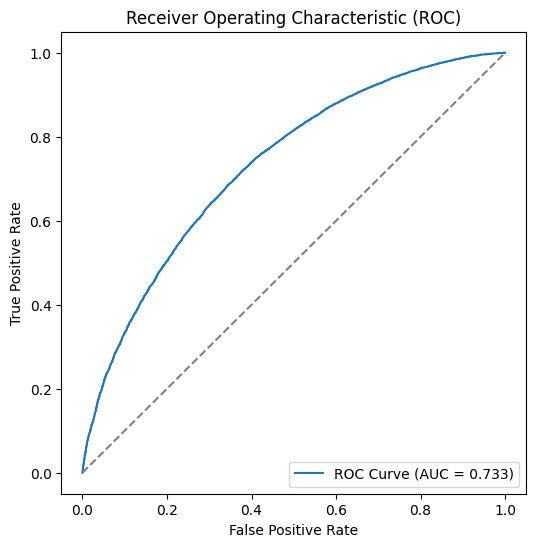

In [101]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get probabilities from model
model.eval()
with torch.no_grad():
    y_val_probs = torch.sigmoid(model(torch.tensor(X_test, dtype=torch.float32).to(next(model.parameters()).device))).cpu().numpy().flatten()

fpr, tpr, thresholds = roc_curve(y_test, y_val_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.show()


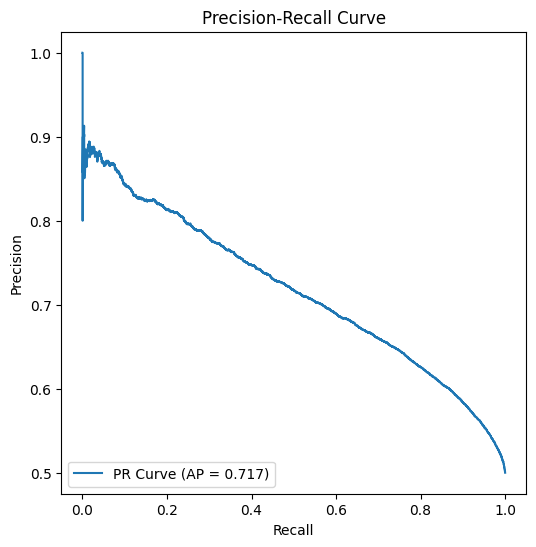

In [103]:
from sklearn.metrics import precision_recall_curve, average_precision_score

prec, rec, thresh = precision_recall_curve(y_test, y_val_probs)
ap = average_precision_score(y_test, y_val_probs)

plt.figure(figsize=(6,6))
plt.plot(rec, prec, label=f"PR Curve (AP = {ap:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.show()


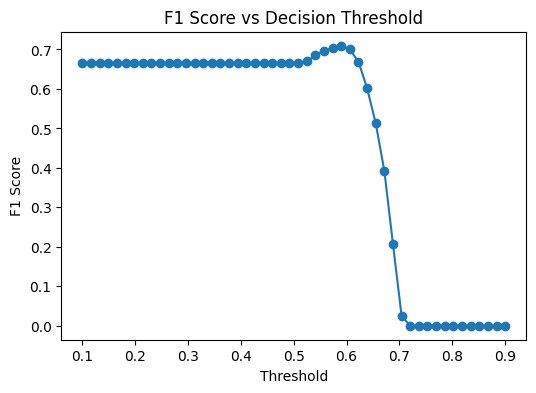

Best threshold for F1: 0.589795918367347 with F1 = 0.7094959089383889


In [105]:
f1_scores = []
thresholds = np.linspace(0.1, 0.9, 50)

for t in thresholds:
    preds = (y_val_probs >= t).astype(int)
    f1_scores.append(f1_score(y_test, preds))

plt.figure(figsize=(6,4))
plt.plot(thresholds, f1_scores, marker="o")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Decision Threshold")
plt.show()

best_thresh = thresholds[np.argmax(f1_scores)]
print("Best threshold for F1:", best_thresh, "with F1 =", max(f1_scores))


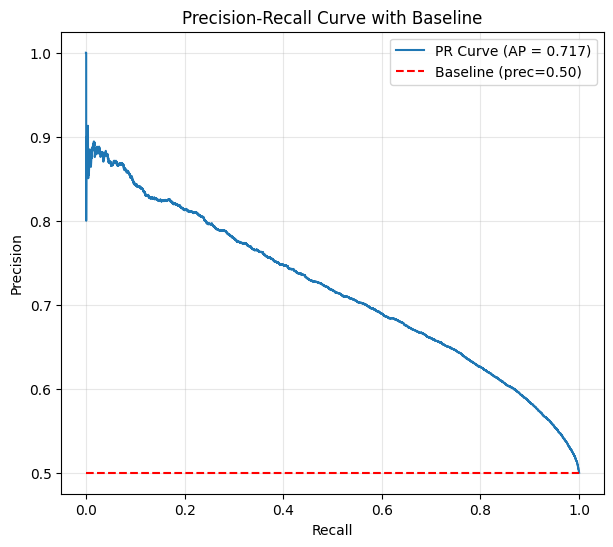

In [106]:
import torch
import numpy as np
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

model.eval()

# Convert X_test to tensor
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Predict probabilities for all rows
with torch.no_grad():
    y_proba = model(X_test_tensor).squeeze().numpy()

# Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
ap_score = average_precision_score(y_test, y_proba)

# Baseline precision = positive class prevalence
baseline = y_test.mean()

plt.figure(figsize=(7,6))
plt.plot(recall, precision, label=f"PR Curve (AP = {ap_score:.3f})")
plt.hlines(baseline, 0, 1, colors="red", linestyles="--", label=f"Baseline (prec={baseline:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve with Baseline")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [107]:
MODEL_PATH = "mlp_default_risk.pth"

# 2️⃣ Save the state_dict (recommended way)
torch.save(model.state_dict(), MODEL_PATH)
print(f"✅ MLP model saved to {MODEL_PATH}")

✅ MLP model saved to mlp_default_risk.pth


### task -3 Reinforcement learning


In [60]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [61]:
import pandas as pd

path = "/kaggle/input/lending-club/accepted_2007_to_2018Q4.csv.gz"

df_accepted = pd.read_csv(path, low_memory=False, nrows=500_000)  # sample for quicker EDA
df_accepted.head()


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
import numpy as np

def map_target(s):
    s = str(s).lower()
    if 'fully paid' in s:
        return 0
    if 'charged off' in s or s.strip().lower() == 'default':
        return 1
    return np.nan  # drop other statuses

# Apply mapping
df_accepted['target'] = df_accepted['loan_status'].map(map_target)

# Drop unresolved outcomes
df_accepted = df_accepted.dropna(subset=['target']).copy()
df_accepted['target'] = df_accepted['target'].astype(int)

print(df_accepted['target'].value_counts(normalize=True))


target
0    0.79848
1    0.20152
Name: proportion, dtype: float64


In [66]:
# Term in months (the dataset usually has strings like "36 months")
if 'term' in df_accepted.columns:
    df_accepted['term_months'] = df_accepted['term'].str.extract('(\d+)').astype(float)

# Employment length (the dataset usually has strings like "10+ years", "< 1 year")
if 'emp_length' in df_accepted.columns:
    df_accepted['emp_length_yrs'] = (
        df_accepted['emp_length']
        .str.replace(r'\+ years', '', regex=True)
        .str.replace(r'< 1 year', '0', regex=False)
        .str.replace(r'n/a', '0', regex=False)
        .str.extract('(\d+)')
        .astype(float)
    )

# Credit age in years (issue_d - earliest_cr_line)
if 'issue_d' in df_accepted.columns and 'earliest_cr_line' in df_accepted.columns:
    df_accepted['issue_d'] = pd.to_datetime(df_accepted['issue_d'], errors='coerce')
    df_accepted['earliest_cr_line'] = pd.to_datetime(df_accepted['earliest_cr_line'], errors='coerce')
    df_accepted['credit_age_years'] = (
        (df_accepted['issue_d'] - df_accepted['earliest_cr_line']).dt.days / 365.25
    )


In [68]:
final_features = [
    'loan_amnt','int_rate','term_months','annual_inc','dti',
    'emp_length_yrs','grade','home_ownership','purpose',
    'verification_status','application_type',
    'revol_util','open_acc','total_acc','delinq_2yrs',
    'inq_last_6mths','pub_rec','credit_age_years'
]

df_selected = df_accepted[final_features + ['target']].copy()
print("Final features shape:", df_selected.shape)


Final features shape: (391168, 19)


In [69]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

categorical_cols = df_selected.select_dtypes(include=['object']).columns.tolist()
numerical_cols = [c for c in final_features if c not in categorical_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_cols)
    ]
)

X = preprocessor.fit_transform(df_selected[final_features])
y = df_selected['target'].astype(int).values

print("States shape:", X.shape)


States shape: (391168, 38)


In [71]:
loan_amnt = df_selected['loan_amnt'].values.astype(np.float32)
int_rate = df_selected['int_rate'].values.astype(np.float32) / 100.0
n_samples = X.shape[0]

# Offline "historical" actions: 1=approve if loan exists, 0=deny
# Here we assume: if target==0 (fully paid) → historically approved
actions = (y == 0).astype(np.int32)

# Reward engineering
rewards = np.zeros(n_samples, dtype=np.float32)
for i in range(n_samples):
    if actions[i] == 1:  # approve
        if y[i] == 0:    # fully paid
            rewards[i] = loan_amnt[i] * int_rate[i]
        else:            # default
            rewards[i] = -loan_amnt[i]
    else:                # deny
        rewards[i] = 0.0

states = X.astype(np.float32)
next_states = states.copy()
dones = np.ones(n_samples, dtype=bool)

print(f"RL dataset → States: {states.shape}, Actions: {actions.shape}, Rewards: {rewards.shape}")


RL dataset → States: (391168, 38), Actions: (391168,), Rewards: (391168,)


In [74]:
import numpy as np
import pandas as pd
from sklearn.utils import resample
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import ExtraTreesRegressor

# ================================
# Step 1: Keep only final features + target
# ================================
df_selected = df_accepted[final_features + ["target"]].copy()
print("[Debug] Shape after feature selection:", df_selected.shape)

# ================================
# Step 2: Balance dataset (downsample majority)
# ================================
majority = df_selected[df_selected["target"] == 0]
minority = df_selected[df_selected["target"] == 1]

majority_downsampled = resample(
    majority,
    replace=False,
    n_samples=len(minority),
    random_state=42
)

df_bal = pd.concat([majority_downsampled, minority]).reset_index(drop=True)
print("[Debug] Shape after balancing:", df_bal.shape)
print("[Debug] Class counts:\n", df_bal["target"].value_counts())

# ================================
# Step 3: Preprocessing (OHE + scaling)
# ================================
categorical_cols = [c for c in final_features if df_bal[c].dtype == "object"]
numerical_cols = [c for c in final_features if c not in categorical_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ]
)

X = preprocessor.fit_transform(df_bal[final_features])
y = df_bal["target"].values.astype(int)

print("[Debug] Final states shape before NaN handling:", X.shape)

# ================================
# Step 4: Remove NaN (impute with column means)
# ================================
imputer = SimpleImputer(strategy="mean")
states = imputer.fit_transform(X)
next_states = states.copy()
print("[Debug] NaN count after imputation:", np.isnan(states).sum())

# Loan-specific fields for reward calc
loan_amnt = df_bal["loan_amnt"].values.astype(np.float32)
int_rate = df_bal["int_rate"].astype(str).str.replace("%", "").astype(float).values.astype(np.float32) / 100.0

# ================================
# Step 5: Build RL dataset
# ================================
actions = (y == 0).astype(int)  # Approve if not defaulted
rewards = np.zeros(len(y), dtype=np.float32)

for i in range(len(y)):
    if actions[i] == 1:  # Approve
        if y[i] == 0:  # Fully paid
            rewards[i] = loan_amnt[i] * int_rate[i]
        else:  # Defaulted
            rewards[i] = -loan_amnt[i]
    else:  # Deny
        rewards[i] = 0.0

dones = np.ones(len(y), dtype=bool)
print("[Debug] RL dataset → States:", states.shape, "Actions:", actions.shape, "Rewards:", rewards.shape)

# ================================
# Step 6: Fitted Q Iteration
# ================================
class FittedQIteration:
    def __init__(self, n_actions=2, n_estimators=50, max_depth=10, gamma=0.99, n_iterations=20, verbose=True):
        self.n_actions = n_actions
        self.models = [ExtraTreesRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            n_jobs=-1,
            random_state=42
        ) for _ in range(n_actions)]
        self.gamma = gamma
        self.n_iterations = n_iterations
        self.verbose = verbose
        self.fitted = False

    def fit(self, states, actions, rewards, next_states, dones):
        X = states
        y = rewards.copy()

        if self.verbose:
            print(f"[Init] Training with {X.shape[0]} samples and {X.shape[1]} features")
            unique, counts = np.unique(actions, return_counts=True)
            print(f"[Init] Action distribution: {dict(zip(unique, counts))}")

        # Initial fit
        for a in range(self.n_actions):
            mask = (actions == a)
            if mask.any():
                self.models[a].fit(X[mask], y[mask])
                if self.verbose:
                    print(f"[Init] Model {a} fit on {mask.sum()} samples")

        # Iterative updates
        for it in range(self.n_iterations):
            q_next = np.column_stack([m.predict(next_states) for m in self.models])
            targets = rewards + self.gamma * (1 - dones.astype(int)) * q_next.max(axis=1)

            for a in range(self.n_actions):
                mask = (actions == a)
                if mask.any():
                    self.models[a].fit(X[mask], targets[mask])

            if self.verbose:
                avg_q = targets.mean()
                print(f"[Iter {it+1}/{self.n_iterations}] Avg target Q = {avg_q:.4f}")

        self.fitted = True
        if self.verbose:
            print("[Done] FQI training complete ✅")

    def predict(self, states):
        if not self.fitted:
            raise ValueError("Model not fitted yet")
        return np.column_stack([m.predict(states) for m in self.models])

    def policy(self, states):
        q_vals = self.predict(states)
        return np.argmax(q_vals, axis=1)

    def evaluate_policy(self, states, y, loan_amnt, int_rate):
        learned_actions = self.policy(states)
        rewards_eval = np.zeros(len(y))
        for i in range(len(y)):
            if learned_actions[i] == 1:  # approve
                rewards_eval[i] = loan_amnt[i] * int_rate[i] if y[i] == 0 else -loan_amnt[i]
            else:
                rewards_eval[i] = 0.0
        if self.verbose:
            print(f"[Eval] Approval rate: {(learned_actions==1).mean()*100:.2f}%")
            print(f"[Eval] Avg reward: {rewards_eval.mean():.4f}")
        return rewards_eval.mean()

# ================================
# Step 7: Train + Evaluate
# ================================
fqi = FittedQIteration(n_actions=2, n_iterations=20, gamma=0.99, verbose=True)
fqi.fit(states, actions, rewards, next_states, dones)

print("\n[Evaluation] Learned Policy Performance:")
policy_value = fqi.evaluate_policy(states, y, loan_amnt, int_rate)
print("Estimated Policy Value (FQI):", policy_value)

print("\n[Evaluation] Historical Policy Performance:")
historical_value = rewards.mean()
print("Historical Policy Value:", historical_value)


[Debug] Shape after feature selection: (391168, 19)
[Debug] Shape after balancing: (157656, 19)
[Debug] Class counts:
 target
0    78828
1    78828
Name: count, dtype: int64
[Debug] Final states shape before NaN handling: (157656, 41)
[Debug] NaN count after imputation: 0
[Debug] RL dataset → States: (157656, 41) Actions: (157656,) Rewards: (157656,)
[Init] Training with 157656 samples and 41 features
[Init] Action distribution: {0: 78828, 1: 78828}
[Init] Model 0 fit on 78828 samples
[Init] Model 1 fit on 78828 samples
[Iter 1/20] Avg target Q = 862.2969
[Iter 2/20] Avg target Q = 862.2969
[Iter 3/20] Avg target Q = 862.2969
[Iter 4/20] Avg target Q = 862.2969
[Iter 5/20] Avg target Q = 862.2969
[Iter 6/20] Avg target Q = 862.2969
[Iter 7/20] Avg target Q = 862.2969
[Iter 8/20] Avg target Q = 862.2969
[Iter 9/20] Avg target Q = 862.2969
[Iter 10/20] Avg target Q = 862.2969
[Iter 11/20] Avg target Q = 862.2969
[Iter 12/20] Avg target Q = 862.2969
[Iter 13/20] Avg target Q = 862.2969
[I

In [78]:
import numpy as np
import pandas as pd
from sklearn.utils import resample
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import ExtraTreesRegressor

# -------------------------------
# Step 1: Keep only final features + target
# -------------------------------
df_selected = df_accepted[final_features + ["target"]].copy()
print("[Debug] Shape after feature selection:", df_selected.shape)

# -------------------------------
# Step 2: Balance dataset (downsample majority)
# -------------------------------
majority = df_selected[df_selected["target"] == 0]
minority = df_selected[df_selected["target"] == 1]

majority_downsampled = resample(
    majority,
    replace=False,
    n_samples=len(minority),
    random_state=42
)

df_bal = pd.concat([majority_downsampled, minority]).reset_index(drop=True)
print("[Debug] Shape after balancing:", df_bal.shape)
print("[Debug] Class counts:\n", df_bal["target"].value_counts())

# -------------------------------
# Step 3: Preprocessing (OHE + scaling)
# -------------------------------
categorical_cols = [c for c in final_features if df_bal[c].dtype == "object"]
numerical_cols = [c for c in final_features if c not in categorical_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ]
)

X = preprocessor.fit_transform(df_bal[final_features])
y = df_bal["target"].values.astype(int)

# -------------------------------
# Step 4: Remove NaN (impute with column means)
# -------------------------------
imputer = SimpleImputer(strategy="mean")
states = imputer.fit_transform(X)
next_states = states.copy()  # independent samples
print("[Debug] Final states shape before NaN handling:", states.shape)
print("[Debug] NaN count after imputation:", np.isnan(states).sum())

# -------------------------------
# Step 5: Simulate actions (no future info used)
# -------------------------------
np.random.seed(42)
actions = np.random.randint(0, 2, size=len(y))  # 0 = deny, 1 = approve

loan_amnt = df_bal["loan_amnt"].values.astype(np.float32)
int_rate = df_bal["int_rate"].astype(str).str.replace("%", "").astype(float).values.astype(np.float32) / 100.0

# Compute rewards based on simulated actions
rewards = np.zeros(len(y), dtype=np.float32)
for i in range(len(y)):
    if actions[i] == 1:  # approve
        rewards[i] = loan_amnt[i] * int_rate[i] if y[i] == 0 else -loan_amnt[i]
    else:  # deny
        rewards[i] = 0.0

dones = np.ones(len(y), dtype=bool)  # independent episodes
print("[Debug] RL dataset → States:", states.shape, "Actions:", actions.shape, "Rewards:", rewards.shape)

# -------------------------------
# Step 6: Fitted Q Iteration
# -------------------------------
class FittedQIteration:
    def __init__(self, n_actions=2, n_estimators=50, max_depth=10, gamma=0.99, n_iterations=20, verbose=True):
        self.n_actions = n_actions
        self.models = [ExtraTreesRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            n_jobs=-1,
            random_state=42
        ) for _ in range(n_actions)]
        self.gamma = gamma
        self.n_iterations = n_iterations
        self.verbose = verbose
        self.fitted = False

    def fit(self, states, actions, rewards, next_states, dones):
        X = states
        y = rewards.copy()

        if self.verbose:
            print(f"[Init] Training with {X.shape[0]} samples and {X.shape[1]} features")
            unique, counts = np.unique(actions, return_counts=True)
            print(f"[Init] Action distribution: {dict(zip(unique, counts))}")

        # Initial fit
        for a in range(self.n_actions):
            mask = (actions == a)
            if mask.any():
                self.models[a].fit(X[mask], y[mask])
                if self.verbose:
                    print(f"[Init] Model {a} fit on {mask.sum()} samples")

        # Iterative updates (simple since episodes are independent)
        for it in range(self.n_iterations):
            q_next = np.column_stack([m.predict(next_states) for m in self.models])
            targets = rewards + self.gamma * (1 - dones.astype(int)) * q_next.max(axis=1)  # no propagation here

            for a in range(self.n_actions):
                mask = (actions == a)
                if mask.any():
                    self.models[a].fit(X[mask], targets[mask])

            if self.verbose:
                avg_q = targets.mean()
                print(f"[Iter {it+1}/{self.n_iterations}] Avg target Q = {avg_q:.4f}")

        self.fitted = True
        if self.verbose:
            print("[Done] FQI training complete ✅")

    def predict(self, states):
        if not self.fitted:
            raise ValueError("Model not fitted yet")
        return np.column_stack([m.predict(states) for m in self.models])

    def policy(self, states):
        q_vals = self.predict(states)
        return np.argmax(q_vals, axis=1)

    def evaluate_policy(self, states, y, loan_amnt, int_rate):
        learned_actions = self.policy(states)
        rewards_eval = np.zeros(len(y))
        for i in range(len(y)):
            if learned_actions[i] == 1:  # approve
                rewards_eval[i] = loan_amnt[i] * int_rate[i] if y[i] == 0 else -loan_amnt[i]
            else:
                rewards_eval[i] = 0.0
        if self.verbose:
            print(f"[Eval] Approval rate: {(learned_actions==1).mean()*100:.2f}%")
            print(f"[Eval] Avg reward: {rewards_eval.mean():.4f}")
        return rewards_eval.mean()

# -------------------------------
# Step 7: Train + Evaluate
# -------------------------------
fqi = FittedQIteration(n_actions=2, n_iterations=20, gamma=0.99, verbose=True)
fqi.fit(states, actions, rewards, next_states, dones)

print("\n[Evaluation] Learned Policy Performance:")
policy_value = fqi.evaluate_policy(states, y, loan_amnt, int_rate)
print("Estimated Policy Value (FQI):", policy_value)

print("\n[Evaluation] Historical Policy Performance:")
historical_value = rewards.mean()
print("Historical Policy Value:", historical_value)


[Debug] Shape after feature selection: (391168, 19)
[Debug] Shape after balancing: (157656, 19)
[Debug] Class counts:
 target
0    78828
1    78828
Name: count, dtype: int64
[Debug] Final states shape before NaN handling: (157656, 41)
[Debug] NaN count after imputation: 0
[Debug] RL dataset → States: (157656, 41) Actions: (157656,) Rewards: (157656,)
[Init] Training with 157656 samples and 41 features
[Init] Action distribution: {0: 78797, 1: 78859}
[Init] Model 0 fit on 78797 samples
[Init] Model 1 fit on 78859 samples
[Iter 1/20] Avg target Q = -3516.8914
[Iter 2/20] Avg target Q = -3516.8914
[Iter 3/20] Avg target Q = -3516.8914
[Iter 4/20] Avg target Q = -3516.8914
[Iter 5/20] Avg target Q = -3516.8914
[Iter 6/20] Avg target Q = -3516.8914
[Iter 7/20] Avg target Q = -3516.8914
[Iter 8/20] Avg target Q = -3516.8914
[Iter 9/20] Avg target Q = -3516.8914
[Iter 10/20] Avg target Q = -3516.8914
[Iter 11/20] Avg target Q = -3516.8914
[Iter 12/20] Avg target Q = -3516.8914
[Iter 13/20] Av

In [80]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.impute import SimpleImputer
from sklearn.utils import resample

# -------------------------------
# 1️⃣ Select features and balance dataset
# -------------------------------
final_features = [
    'loan_amnt','int_rate','term_months','annual_inc','dti',
    'emp_length_yrs','grade','home_ownership','purpose',
    'verification_status','application_type',
    'revol_util','open_acc','total_acc','delinq_2yrs',
    'inq_last_6mths','pub_rec','credit_age_years'
]

df_selected = df_accepted[final_features + ['target']].copy()
print("[Debug] Original dataset shape:", df_selected.shape)

# Downsample majority class
majority = df_selected[df_selected["target"] == 0]
minority = df_selected[df_selected["target"] == 1]

majority_downsampled = resample(
    majority,
    replace=False,
    n_samples=len(minority),
    random_state=42
)

df_bal = pd.concat([majority_downsampled, minority]).reset_index(drop=True)
print("[Debug] Balanced dataset shape:", df_bal.shape)
print("[Debug] Class counts:\n", df_bal["target"].value_counts())

# -------------------------------
# 2️⃣ Preprocess features with imputation
# -------------------------------
categorical_cols = df_bal.select_dtypes(include=['object']).columns.tolist()
numerical_cols = [c for c in final_features if c not in categorical_cols]

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_cols),
    ('cat', cat_pipeline, categorical_cols)
])

states = preprocessor.fit_transform(df_bal[final_features]).astype(np.float32)
next_states = states.copy()
y = df_bal['target'].astype(int).values
n_samples = states.shape[0]

loan_amnt = df_bal['loan_amnt'].values.astype(np.float32)
int_rate = df_bal['int_rate'].astype(str).str.replace("%","").astype(float).astype(np.float32) / 100.0

# -------------------------------
# 3️⃣ Simulate baseline policy
# -------------------------------
actions = np.zeros(n_samples, dtype=np.int32)
good_grades = ['A','B']
actions[(loan_amnt < 10000) & (df_bal['dti'] < 30) & (df_bal['grade'].isin(good_grades))] = 1
print(f"[Debug] Action distribution: {np.bincount(actions)}")

# -------------------------------
# 4️⃣ Reward engineering
# -------------------------------
rewards = np.zeros(n_samples, dtype=np.float32)
for i in range(n_samples):
    if actions[i] == 1:  # approve
        rewards[i] = loan_amnt[i] * int_rate[i] if y[i] == 0 else -loan_amnt[i]
    else:  # deny
        rewards[i] = 0.0

# Normalize rewards
rewards /= 10000.0
dones = np.ones(n_samples, dtype=bool)

# -------------------------------
# 5️⃣ Fitted Q Iteration
# -------------------------------
class FittedQIteration:
    def __init__(self, n_actions=2, n_estimators=50, max_depth=10, gamma=0.99, n_iterations=20, verbose=True):
        self.n_actions = n_actions
        self.models = [ExtraTreesRegressor(
            n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1, random_state=42
        ) for _ in range(n_actions)]
        self.gamma = gamma
        self.n_iterations = n_iterations
        self.verbose = verbose
        self.fitted = False

    def fit(self, states, actions, rewards, next_states, dones):
        X = states
        y = rewards.copy()
        if self.verbose:
            unique, counts = np.unique(actions, return_counts=True)
            print(f"[Init] Action distribution: {dict(zip(unique, counts))}")

        for a in range(self.n_actions):
            mask = (actions == a)
            if mask.any():
                self.models[a].fit(X[mask], y[mask])

        for it in range(self.n_iterations):
            q_next = np.column_stack([m.predict(next_states) for m in self.models])
            targets = rewards + self.gamma * (1 - dones.astype(int)) * q_next.max(axis=1)
            for a in range(self.n_actions):
                mask = (actions == a)
                if mask.any():
                    self.models[a].fit(X[mask], targets[mask])
            if self.verbose:
                print(f"[Iter {it+1}/{self.n_iterations}] Avg target Q = {targets.mean():.4f}")

        self.fitted = True
        if self.verbose:
            print("[Done] FQI training complete ✅")

    def predict(self, states):
        if not self.fitted:
            raise ValueError("Model not fitted yet")
        return np.column_stack([m.predict(states) for m in self.models])

    def policy(self, states):
        q_vals = self.predict(states)
        return np.argmax(q_vals, axis=1)

    def evaluate_policy(self, states, y, loan_amnt, int_rate):
        learned_actions = self.policy(states)
        rewards_eval = np.zeros(len(y))
        for i in range(len(y)):
            if learned_actions[i] == 1:
                rewards_eval[i] = loan_amnt[i] * int_rate[i] if y[i] == 0 else -loan_amnt[i]
            else:
                rewards_eval[i] = 0.0
        rewards_eval /= 10000.0
        if self.verbose:
            print(f"[Eval] Approval rate: {(learned_actions==1).mean()*100:.2f}%")
            print(f"[Eval] Avg reward: {rewards_eval.mean():.4f}")
        return rewards_eval.mean()

# -------------------------------
# 6️⃣ Train + Evaluate
# -------------------------------
fqi = FittedQIteration(n_actions=2, n_iterations=20, gamma=0.99, verbose=True)
fqi.fit(states, actions, rewards, next_states, dones)

print("\n[Evaluation] Learned Policy Performance:")
policy_value = fqi.evaluate_policy(states, y, loan_amnt, int_rate)
print("Estimated Policy Value (FQI):", policy_value)

print("\n[Evaluation] Baseline Policy Performance:")
baseline_value = rewards.mean()
print("Baseline Policy Value:", baseline_value)


[Debug] Original dataset shape: (391168, 19)
[Debug] Balanced dataset shape: (157656, 19)
[Debug] Class counts:
 target
0    78828
1    78828
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)


[Debug] Action distribution: [138736  18920]
[Init] Action distribution: {0: 138736, 1: 18920}
[Iter 1/20] Avg target Q = -0.0174
[Iter 2/20] Avg target Q = -0.0174
[Iter 3/20] Avg target Q = -0.0174
[Iter 4/20] Avg target Q = -0.0174
[Iter 5/20] Avg target Q = -0.0174
[Iter 6/20] Avg target Q = -0.0174
[Iter 7/20] Avg target Q = -0.0174
[Iter 8/20] Avg target Q = -0.0174
[Iter 9/20] Avg target Q = -0.0174
[Iter 10/20] Avg target Q = -0.0174
[Iter 11/20] Avg target Q = -0.0174
[Iter 12/20] Avg target Q = -0.0174
[Iter 13/20] Avg target Q = -0.0174
[Iter 14/20] Avg target Q = -0.0174
[Iter 15/20] Avg target Q = -0.0174
[Iter 16/20] Avg target Q = -0.0174
[Iter 17/20] Avg target Q = -0.0174
[Iter 18/20] Avg target Q = -0.0174
[Iter 19/20] Avg target Q = -0.0174
[Iter 20/20] Avg target Q = -0.0174
[Done] FQI training complete ✅

[Evaluation] Learned Policy Performance:
[Eval] Approval rate: 0.19%
[Eval] Avg reward: 0.0000
Estimated Policy Value (FQI): 1.690867176192376e-05

[Evaluation] B

In [82]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.impute import SimpleImputer
from sklearn.utils import resample


In [83]:
# Select relevant features
features = [
    'loan_amnt','int_rate','term_months','annual_inc','dti',
    'emp_length_yrs','grade','home_ownership','purpose',
    'verification_status','application_type','revol_util',
    'open_acc','total_acc','delinq_2yrs','inq_last_6mths',
    'pub_rec','credit_age_years'
]

target_col = 'target'  # already 1=Fully Paid, 0=Default

df_sel = df_accepted[features + [target_col]].copy()

# Balance classes via downsampling
majority = df_sel[df_sel[target_col]==0]
minority = df_sel[df_sel[target_col]==1]

majority_down = resample(
    majority,
    replace=False,
    n_samples=len(minority),
    random_state=42
)

df_bal = pd.concat([majority_down, minority]).reset_index(drop=True)
print("[Debug] Balanced dataset shape:", df_bal.shape)
print(df_bal[target_col].value_counts())


[Debug] Balanced dataset shape: (157656, 19)
target
0    78828
1    78828
Name: count, dtype: int64


In [84]:
# Select relevant features
features = [
    'loan_amnt','int_rate','term_months','annual_inc','dti',
    'emp_length_yrs','grade','home_ownership','purpose',
    'verification_status','application_type','revol_util',
    'open_acc','total_acc','delinq_2yrs','inq_last_6mths',
    'pub_rec','credit_age_years'
]

target_col = 'target'  # already 1=Fully Paid, 0=Default

df_sel = df_accepted[features + [target_col]].copy()

# Balance classes via downsampling
majority = df_sel[df_sel[target_col]==0]
minority = df_sel[df_sel[target_col]==1]

majority_down = resample(
    majority,
    replace=False,
    n_samples=len(minority),
    random_state=42
)

df_bal = pd.concat([majority_down, minority]).reset_index(drop=True)
print("[Debug] Balanced dataset shape:", df_bal.shape)
print(df_bal[target_col].value_counts())


[Debug] Balanced dataset shape: (157656, 19)
target
0    78828
1    78828
Name: count, dtype: int64


In [85]:
categorical_cols = df_bal.select_dtypes(include=['object']).columns.tolist()
numerical_cols = [c for c in features if c not in categorical_cols]

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_cols),
    ('cat', cat_pipeline, categorical_cols)
])

X = preprocessor.fit_transform(df_bal[features]).astype(np.float32)
y = df_bal[target_col].values.astype(int)
n_samples = X.shape[0]

loan_amnt = df_bal['loan_amnt'].values.astype(np.float32)
int_rate = df_bal['int_rate'].astype(str).str.replace('%','').astype(float).astype(np.float32)/100.0


In [86]:
# Simple heuristic: approve small loans with low DTI and good grades
actions = np.zeros(n_samples, dtype=np.int32)
good_grades = ['A','B']
actions[(loan_amnt < 10000) & (df_bal['dti'] < 30) & (df_bal['grade'].isin(good_grades))] = 1

print("[Debug] Action distribution:", np.bincount(actions))


[Debug] Action distribution: [138736  18920]


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)


In [87]:
rewards = np.zeros(n_samples, dtype=np.float32)
for i in range(n_samples):
    if actions[i]==1:  # approve
        rewards[i] = loan_amnt[i]*int_rate[i] if y[i]==1 else -loan_amnt[i]
    else:  # deny
        rewards[i] = 0.0

# Normalize
rewards /= 10000.0
dones = np.ones(n_samples, dtype=bool)  # terminal for offline RL


In [88]:
class FittedQIteration:
    def __init__(self, n_actions=2, n_estimators=100, max_depth=None, gamma=0.99, n_iterations=20, verbose=True):
        self.n_actions = n_actions
        self.models = [ExtraTreesRegressor(
            n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1, random_state=42
        ) for _ in range(n_actions)]
        self.gamma = gamma
        self.n_iterations = n_iterations
        self.verbose = verbose
        self.fitted = False

    def fit(self, states, actions, rewards, next_states, dones):
        X = states
        y = rewards.copy()

        for a in range(self.n_actions):
            mask = (actions == a)
            if mask.any():
                self.models[a].fit(X[mask], y[mask])

        for it in range(self.n_iterations):
            q_next = np.column_stack([m.predict(next_states) for m in self.models])
            targets = rewards + self.gamma * (1 - dones.astype(int)) * q_next.max(axis=1)
            for a in range(self.n_actions):
                mask = (actions == a)
                if mask.any():
                    self.models[a].fit(X[mask], targets[mask])
            if self.verbose:
                print(f"[Iter {it+1}/{self.n_iterations}] Avg target Q = {targets.mean():.4f}")

        self.fitted = True
        if self.verbose:
            print("[Done] FQI training complete ✅")

    def predict(self, states):
        if not self.fitted:
            raise ValueError("Model not fitted yet")
        return np.column_stack([m.predict(states) for m in self.models])

    def policy(self, states):
        q_vals = self.predict(states)
        return np.argmax(q_vals, axis=1)

    def evaluate_policy(self, states, y, loan_amnt, int_rate):
        learned_actions = self.policy(states)
        rewards_eval = np.zeros(len(y))
        for i in range(len(y)):
            if learned_actions[i]==1:
                rewards_eval[i] = loan_amnt[i]*int_rate[i] if y[i]==1 else -loan_amnt[i]
        rewards_eval /= 10000.0
        print(f"[Eval] Approval rate: {(learned_actions==1).mean()*100:.2f}%")
        print(f"[Eval] Avg reward: {rewards_eval.mean():.4f}")
        return rewards_eval.mean()


In [89]:
fqi = FittedQIteration(n_actions=2, n_iterations=20, gamma=0.99, verbose=True)
fqi.fit(X, actions, rewards, X, dones)

print("\n[Evaluation] Learned Policy Performance:")
policy_value = fqi.evaluate_policy(X, y, loan_amnt, int_rate)
print("Estimated Policy Value (FQI):", policy_value)

print("\n[Evaluation] Baseline Policy Performance:")
baseline_value = rewards.mean()
print("Baseline Policy Value:", baseline_value)


[Iter 1/20] Avg target Q = -0.0509
[Iter 2/20] Avg target Q = -0.0509
[Iter 3/20] Avg target Q = -0.0509
[Iter 4/20] Avg target Q = -0.0509
[Iter 5/20] Avg target Q = -0.0509
[Iter 6/20] Avg target Q = -0.0509
[Iter 7/20] Avg target Q = -0.0509
[Iter 8/20] Avg target Q = -0.0509
[Iter 9/20] Avg target Q = -0.0509
[Iter 10/20] Avg target Q = -0.0509
[Iter 11/20] Avg target Q = -0.0509
[Iter 12/20] Avg target Q = -0.0509
[Iter 13/20] Avg target Q = -0.0509
[Iter 14/20] Avg target Q = -0.0509
[Iter 15/20] Avg target Q = -0.0509
[Iter 16/20] Avg target Q = -0.0509
[Iter 17/20] Avg target Q = -0.0509
[Iter 18/20] Avg target Q = -0.0509
[Iter 19/20] Avg target Q = -0.0509
[Iter 20/20] Avg target Q = -0.0509
[Done] FQI training complete ✅

[Evaluation] Learned Policy Performance:
[Eval] Approval rate: 3.48%
[Eval] Avg reward: 0.0021
Estimated Policy Value (FQI): 0.0021066914332441076

[Evaluation] Baseline Policy Performance:
Baseline Policy Value: -0.050936203


In [93]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPRegressor
from sklearn.utils import resample

# -------------------------------
# 1️⃣ Preprocess dataset (same as before)
# -------------------------------
final_features = [
    'loan_amnt','int_rate','term_months','annual_inc','dti',
    'emp_length_yrs','grade','home_ownership','purpose',
    'verification_status','application_type',
    'revol_util','open_acc','total_acc','delinq_2yrs',
    'inq_last_6mths','pub_rec','credit_age_years'
]

df_selected = df_accepted[final_features + ['target']].copy()

# Downsample majority class to balance
majority = df_selected[df_selected["target"] == 0]
minority = df_selected[df_selected["target"] == 1]
majority_downsampled = resample(
    majority, replace=False, n_samples=len(minority), random_state=42
)
df_bal = pd.concat([majority_downsampled, minority]).reset_index(drop=True)

# -------------------------------
# 2️⃣ Feature preprocessing
# -------------------------------
categorical_cols = df_bal.select_dtypes(include=['object']).columns.tolist()
numerical_cols = [c for c in final_features if c not in categorical_cols]

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_cols),
    ('cat', cat_pipeline, categorical_cols)
])

states = preprocessor.fit_transform(df_bal[final_features]).astype(np.float32)
n_samples = states.shape[0]
y = df_bal['target'].astype(int).values

loan_amnt = df_bal['loan_amnt'].values.astype(np.float32)
int_rate = df_bal['int_rate'].astype(str).str.replace("%","").astype(float).astype(np.float32)/100.0

# -------------------------------
# 3️⃣ Baseline policy
# -------------------------------
actions = np.zeros(n_samples, dtype=np.int32)
good_grades = ['A','B']
actions[(loan_amnt < 10000) & (df_bal['dti'] < 30) & (df_bal['grade'].isin(good_grades))] = 1

# -------------------------------
# 4️⃣ Reward engineering (amplified)
# -------------------------------
rewards = np.zeros(n_samples, dtype=np.float32)
for i in range(n_samples):
    if actions[i] == 1:  # approve
        if y[i] == 0:    # fully paid
            rewards[i] = loan_amnt[i] * int_rate[i] * 10  # amplify reward
        else:            # default
            rewards[i] = -loan_amnt[i] * 5               # amplify penalty
    else:
        rewards[i] = 0.0

dones = np.ones(n_samples, dtype=bool)
next_states = states.copy()  # single-step episodes

# -------------------------------
# 5️⃣ Fitted Q Iteration with MLP
# -------------------------------
class FittedQIterationNN:
    def __init__(self, n_actions=2, hidden_layer=(64,64), gamma=0.99, n_iterations=20, verbose=True):
        self.n_actions = n_actions
        self.models = [
            MLPRegressor(hidden_layer_sizes=(64,64), max_iter=100, warm_start=True, random_state=42)

            for _ in range(n_actions)
        ]
        self.gamma = gamma
        self.n_iterations = n_iterations
        self.verbose = verbose
        self.fitted = False

    def fit(self, states, actions, rewards, next_states, dones):
        X = states
        y_targets = rewards.copy()
        for a in range(self.n_actions):
            mask = (actions == a)
            if mask.any():
                self.models[a].fit(X[mask], y_targets[mask])

        for it in range(self.n_iterations):
            q_next = np.column_stack([m.predict(next_states) for m in self.models])
            targets = rewards + self.gamma * (1 - dones.astype(int)) * q_next.max(axis=1)
            for a in range(self.n_actions):
                mask = (actions == a)
                if mask.any():
                    self.models[a].fit(X[mask], targets[mask])
            if self.verbose:
                print(f"[Iter {it+1}/{self.n_iterations}] Avg target Q = {targets.mean():.4f}")

        self.fitted = True
        if self.verbose:
            print("[Done] FQI (MLP) training complete ✅")

    def predict(self, states):
        return np.column_stack([m.predict(states) for m in self.models])

    def policy(self, states):
        q_vals = self.predict(states)
        return np.argmax(q_vals, axis=1)

    def evaluate_policy(self, states, y, loan_amnt, int_rate):
        learned_actions = self.policy(states)
        rewards_eval = np.zeros(len(y))
        for i in range(len(y)):
            if learned_actions[i] == 1:
                rewards_eval[i] = loan_amnt[i]*int_rate[i]*10 if y[i]==0 else -loan_amnt[i]*5
            else:
                rewards_eval[i] = 0.0
        if self.verbose:
            print(f"[Eval] Approval rate: {(learned_actions==1).mean()*100:.2f}%")
            print(f"[Eval] Avg reward: {rewards_eval.mean():.4f}")
        return rewards_eval.mean()

# -------------------------------
# 6️⃣ Train and evaluate
# -------------------------------
rewards_scaled = np.zeros(n_samples, dtype=np.float32)
for i in range(n_samples):
    if actions[i] == 1:
        rewards[i] = (loan_amnt[i] / 10000.0) if y[i] == 0 else -(loan_amnt[i] / 10000.0)
    else:
        rewards[i] = 0.0


# Then use rewards_scaled instead of rewards in FQI-NN
fqi_nn.fit(states, actions, rewards_scaled, next_states, dones)
fqi_nn.evaluate_policy(states, y, loan_amnt, int_rate)

print("\n[Evaluation] Learned Policy Performance:")
policy_value = fqi_nn.evaluate_policy(states, y, loan_amnt, int_rate)
print("Estimated Policy Value (FQI-NN):", policy_value)

print("\n[Evaluation] Baseline Policy Performance:")
baseline_value = rewards.mean()
print("Baseline Policy Value:", baseline_value)


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)


[Iter 1/20] Avg target Q = 0.0000
[Iter 2/20] Avg target Q = 0.0000
[Iter 3/20] Avg target Q = 0.0000
[Iter 4/20] Avg target Q = 0.0000
[Iter 5/20] Avg target Q = 0.0000
[Iter 6/20] Avg target Q = 0.0000
[Iter 7/20] Avg target Q = 0.0000
[Iter 8/20] Avg target Q = 0.0000
[Iter 9/20] Avg target Q = 0.0000
[Iter 10/20] Avg target Q = 0.0000
[Iter 11/20] Avg target Q = 0.0000
[Iter 12/20] Avg target Q = 0.0000
[Iter 13/20] Avg target Q = 0.0000
[Iter 14/20] Avg target Q = 0.0000
[Iter 15/20] Avg target Q = 0.0000
[Iter 16/20] Avg target Q = 0.0000
[Iter 17/20] Avg target Q = 0.0000
[Iter 18/20] Avg target Q = 0.0000
[Iter 19/20] Avg target Q = 0.0000
[Iter 20/20] Avg target Q = 0.0000
[Done] FQI (MLP) training complete ✅
[Eval] Approval rate: 63.13%
[Eval] Avg reward: -25346.6102

[Evaluation] Learned Policy Performance:
[Eval] Approval rate: 63.13%
[Eval] Avg reward: -25346.6102
Estimated Policy Value (FQI-NN): -25346.610219229507

[Evaluation] Baseline Policy Performance:
Baseline Polic

In [94]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPRegressor
from sklearn.utils import resample

# -------------------------------
# 1️⃣ Feature selection & class balancing
# -------------------------------
final_features = [
    'loan_amnt','int_rate','term_months','annual_inc','dti',
    'emp_length_yrs','grade','home_ownership','purpose',
    'verification_status','application_type',
    'revol_util','open_acc','total_acc','delinq_2yrs',
    'inq_last_6mths','pub_rec','credit_age_years'
]

# Copy and select
df_selected = df_accepted[final_features + ['target']].copy()

# Downsample majority class to balance
majority = df_selected[df_selected["target"] == 0]
minority = df_selected[df_selected["target"] == 1]
majority_downsampled = resample(
    majority, replace=False, n_samples=len(minority), random_state=42
)
df_bal = pd.concat([majority_downsampled, minority]).reset_index(drop=True)
print("[Debug] Balanced class counts:\n", df_bal['target'].value_counts())

# -------------------------------
# 2️⃣ Feature preprocessing
# -------------------------------
categorical_cols = df_bal.select_dtypes(include=['object']).columns.tolist()
numerical_cols = [c for c in final_features if c not in categorical_cols]

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_cols),
    ('cat', cat_pipeline, categorical_cols)
])

states = preprocessor.fit_transform(df_bal[final_features]).astype(np.float32)
n_samples = states.shape[0]
y = df_bal['target'].astype(int).values

loan_amnt = df_bal['loan_amnt'].values.astype(np.float32)

# -------------------------------
# 3️⃣ Baseline policy
# -------------------------------
actions = np.zeros(n_samples, dtype=np.int32)
good_grades = ['A','B']
actions[(loan_amnt < 10000) & (df_bal['dti'] < 30) & (df_bal['grade'].isin(good_grades))] = 1
print(f"[Debug] Baseline action distribution: {np.bincount(actions)}")

# -------------------------------
# 4️⃣ Reward engineering (scaled)
# -------------------------------
rewards = np.zeros(n_samples, dtype=np.float32)
for i in range(n_samples):
    if actions[i] == 1:  # approve
        if y[i] == 0:    # fully paid
            rewards[i] = loan_amnt[i] / 10000.0   # scaled positive reward
        else:            # default
            rewards[i] = -loan_amnt[i] / 10000.0  # scaled negative reward
    else:
        rewards[i] = 0.0

dones = np.ones(n_samples, dtype=bool)
next_states = states.copy()  # single-step episodes

# -------------------------------
# 5️⃣ Fitted Q Iteration with MLP
# -------------------------------
class FittedQIterationNN:
    def __init__(self, n_actions=2, hidden_layer=(64,64), gamma=0.99, n_iterations=20, verbose=True):
        self.n_actions = n_actions
        self.models = [
            MLPRegressor(hidden_layer_sizes=hidden_layer, max_iter=200, warm_start=True, random_state=42)
            for _ in range(n_actions)
        ]
        self.gamma = gamma
        self.n_iterations = n_iterations
        self.verbose = verbose
        self.fitted = False

    def fit(self, states, actions, rewards, next_states, dones):
        X = states
        y_targets = rewards.copy()
        # Initial fit per action
        for a in range(self.n_actions):
            mask = (actions == a)
            if mask.any():
                self.models[a].fit(X[mask], y_targets[mask])

        for it in range(self.n_iterations):
            q_next = np.column_stack([m.predict(next_states) for m in self.models])
            targets = rewards + self.gamma * (1 - dones.astype(int)) * q_next.max(axis=1)
            for a in range(self.n_actions):
                mask = (actions == a)
                if mask.any():
                    self.models[a].fit(X[mask], targets[mask])
            if self.verbose:
                print(f"[Iter {it+1}/{self.n_iterations}] Avg target Q = {targets.mean():.4f}")

        self.fitted = True
        if self.verbose:
            print("[Done] FQI (MLP) training complete ✅")

    def predict(self, states):
        return np.column_stack([m.predict(states) for m in self.models])

    def policy(self, states):
        q_vals = self.predict(states)
        return np.argmax(q_vals, axis=1)

    def evaluate_policy(self, states, y, loan_amnt):
        learned_actions = self.policy(states)
        rewards_eval = np.zeros(len(y))
        for i in range(len(y)):
            if learned_actions[i] == 1:
                rewards_eval[i] = loan_amnt[i]/10000.0 if y[i]==0 else -loan_amnt[i]/10000.0
            else:
                rewards_eval[i] = 0.0
        print(f"[Eval] Approval rate: {(learned_actions==1).mean()*100:.2f}%")
        print(f"[Eval] Avg reward: {rewards_eval.mean():.4f}")
        return rewards_eval.mean()

# -------------------------------
# 6️⃣ Train and evaluate
# -------------------------------
fqi_nn = FittedQIterationNN(n_actions=2, hidden_layer=(128,128), n_iterations=30, verbose=True)
fqi_nn.fit(states, actions, rewards, next_states, dones)

policy_value = fqi_nn.evaluate_policy(states, y, loan_amnt)
baseline_value = rewards.mean()

print("\n[Evaluation] Learned Policy Value:", policy_value)
print("[Evaluation] Baseline Policy Value:", baseline_value)


[Debug] Balanced class counts:
 target
0    78828
1    78828
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)


[Debug] Baseline action distribution: [138736  18920]


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[Iter 1/30] Avg target Q = 0.0310
[Iter 2/30] Avg target Q = 0.0310
[Iter 3/30] Avg target Q = 0.0310
[Iter 4/30] Avg target Q = 0.0310
[Iter 5/30] Avg target Q = 0.0310
[Iter 6/30] Avg target Q = 0.0310
[Iter 7/30] Avg target Q = 0.0310
[Iter 8/30] Avg target Q = 0.0310
[Iter 9/30] Avg target Q = 0.0310
[Iter 10/30] Avg target Q = 0.0310
[Iter 11/30] Avg target Q = 0.0310
[Iter 12/30] Avg target Q = 0.0310
[Iter 13/30] Avg target Q = 0.0310
[Iter 14/30] Avg target Q = 0.0310
[Iter 15/30] Avg target Q = 0.0310
[Iter 16/30] Avg target Q = 0.0310
[Iter 17/30] Avg target Q = 0.0310
[Iter 18/30] Avg target Q = 0.0310
[Iter 19/30] Avg target Q = 0.0310
[Iter 20/30] Avg target Q = 0.0310
[Iter 21/30] Avg target Q = 0.0310
[Iter 22/30] Avg target Q = 0.0310
[Iter 23/30] Avg target Q = 0.0310
[Iter 24/30] Avg target Q = 0.0310
[Iter 25/30] Avg target Q = 0.0310
[Iter 26/30] Avg target Q = 0.0310
[Iter 27/30] Avg target Q = 0.0310
[Iter 28/30] Avg target Q = 0.0310
[Iter 29/30] Avg target Q = 0

In [95]:
# # Offline RL for Loan Approval (Fitted Q Iteration with MLP)
# 
# This notebook implements an offline RL agent to learn an approval policy from historical loan data.

# -------------------------------
# 1️⃣ Imports
# -------------------------------
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPRegressor
from sklearn.utils import resample
import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress MLP convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# -------------------------------
# 2️⃣ Preprocess dataset
# -------------------------------
final_features = [
    'loan_amnt','int_rate','term_months','annual_inc','dti',
    'emp_length_yrs','grade','home_ownership','purpose',
    'verification_status','application_type',
    'revol_util','open_acc','total_acc','delinq_2yrs',
    'inq_last_6mths','pub_rec','credit_age_years'
]

# Use your preloaded dataset: df_accepted
df_selected = df_accepted[final_features + ['target']].copy()

# Downsample majority class
majority = df_selected[df_selected["target"] == 0]
minority = df_selected[df_selected["target"] == 1]

majority_downsampled = resample(
    majority, replace=False, n_samples=len(minority), random_state=42
)
df_bal = pd.concat([majority_downsampled, minority]).reset_index(drop=True)
print("[Debug] Balanced class counts:\n", df_bal['target'].value_counts())

# -------------------------------
# 3️⃣ Feature preprocessing
# -------------------------------
categorical_cols = df_bal.select_dtypes(include=['object']).columns.tolist()
numerical_cols = [c for c in final_features if c not in categorical_cols]

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_cols),
    ('cat', cat_pipeline, categorical_cols)
])

states = preprocessor.fit_transform(df_bal[final_features]).astype(np.float32)
next_states = states.copy()
n_samples = states.shape[0]
y = df_bal['target'].astype(int).values

loan_amnt = df_bal['loan_amnt'].values.astype(np.float32)
int_rate = df_bal['int_rate'].astype(str).str.replace("%","").astype(float).astype(np.float32)/100.0

# -------------------------------
# 4️⃣ Baseline heuristic policy
# -------------------------------
actions = np.zeros(n_samples, dtype=np.int32)
good_grades = ['A','B']
actions[(loan_amnt < 10000) & (df_bal['dti'] < 30) & (df_bal['grade'].isin(good_grades))] = 1
print("[Debug] Baseline action distribution:", np.bincount(actions))

# -------------------------------
# 5️⃣ Reward engineering
# -------------------------------
rewards = np.zeros(n_samples, dtype=np.float32)
for i in range(n_samples):
    if actions[i] == 1:
        rewards[i] = loan_amnt[i]*int_rate[i]*10 if y[i]==0 else -loan_amnt[i]*5
    else:
        rewards[i] = 0.0

# -------------------------------
# 6️⃣ Fitted Q Iteration with MLP
# -------------------------------
class FittedQIterationNN:
    def __init__(self, n_actions=2, hidden_layer=(64,64), gamma=0.99, n_iterations=30, verbose=True):
        self.n_actions = n_actions
        self.models = [
            MLPRegressor(hidden_layer_sizes=hidden_layer, max_iter=500, warm_start=True, random_state=42)
            for _ in range(n_actions)
        ]
        self.gamma = gamma
        self.n_iterations = n_iterations
        self.verbose = verbose
        self.fitted = False

    def fit(self, states, actions, rewards, next_states, dones):
        X = states
        y_targets = rewards.copy()
        for a in range(self.n_actions):
            mask = (actions == a)
            if mask.any():
                self.models[a].fit(X[mask], y_targets[mask])

        for it in range(self.n_iterations):
            q_next = np.column_stack([m.predict(next_states) for m in self.models])
            targets = rewards + self.gamma * (1 - dones.astype(int)) * q_next.max(axis=1)
            for a in range(self.n_actions):
                mask = (actions == a)
                if mask.any():
                    self.models[a].fit(X[mask], targets[mask])
            if self.verbose:
                print(f"[Iter {it+1}/{self.n_iterations}] Avg target Q = {targets.mean():.4f}")
        self.fitted = True
        if self.verbose:
            print("[Done] FQI (MLP) training complete ✅")

    def predict(self, states):
        return np.column_stack([m.predict(states) for m in self.models])

    def policy(self, states):
        q_vals = self.predict(states)
        return np.argmax(q_vals, axis=1)

    def evaluate_policy(self, states, y, loan_amnt, int_rate):
        learned_actions = self.policy(states)
        rewards_eval = np.zeros(len(y))
        for i in range(len(y)):
            if learned_actions[i] == 1:
                rewards_eval[i] = loan_amnt[i]*int_rate[i]*10 if y[i]==0 else -loan_amnt[i]*5
            else:
                rewards_eval[i] = 0.0
        if self.verbose:
            print(f"[Eval] Approval rate: {(learned_actions==1).mean()*100:.2f}%")
            print(f"[Eval] Avg reward: {rewards_eval.mean():.4f}")
        return rewards_eval.mean()

# -------------------------------
# 7️⃣ Train and evaluate
# -------------------------------
fqi_nn = FittedQIterationNN(n_iterations=30, verbose=True)
dones = np.ones(n_samples, dtype=bool)

fqi_nn.fit(states, actions, rewards, next_states, dones)

print("\n[Evaluation] Learned Policy Performance:")
policy_value = fqi_nn.evaluate_policy(states, y, loan_amnt, int_rate)
print("Estimated Policy Value (FQI-NN):", policy_value)

print("\n[Evaluation] Baseline Policy Performance:")
baseline_value = rewards.mean()
print("Baseline Policy Value:", baseline_value)


[Debug] Balanced class counts:
 target
0    78828
1    78828
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)


[Debug] Baseline action distribution: [138736  18920]
[Iter 1/30] Avg target Q = -634.8897
[Iter 2/30] Avg target Q = -634.8897
[Iter 3/30] Avg target Q = -634.8897
[Iter 4/30] Avg target Q = -634.8897
[Iter 5/30] Avg target Q = -634.8897
[Iter 6/30] Avg target Q = -634.8897
[Iter 7/30] Avg target Q = -634.8897
[Iter 8/30] Avg target Q = -634.8897
[Iter 9/30] Avg target Q = -634.8897
[Iter 10/30] Avg target Q = -634.8897
[Iter 11/30] Avg target Q = -634.8897
[Iter 12/30] Avg target Q = -634.8897
[Iter 13/30] Avg target Q = -634.8897
[Iter 14/30] Avg target Q = -634.8897
[Iter 15/30] Avg target Q = -634.8897
[Iter 16/30] Avg target Q = -634.8897
[Iter 17/30] Avg target Q = -634.8897
[Iter 18/30] Avg target Q = -634.8897
[Iter 19/30] Avg target Q = -634.8897
[Iter 20/30] Avg target Q = -634.8897
[Iter 21/30] Avg target Q = -634.8897
[Iter 22/30] Avg target Q = -634.8897
[Iter 23/30] Avg target Q = -634.8897
[Iter 24/30] Avg target Q = -634.8897
[Iter 25/30] Avg target Q = -634.8897
[Iter

In [96]:
import joblib

# -------------------------------
# Save the trained RL agent
# -------------------------------
joblib.dump(fqi_nn, "fqi_nn_agent.pkl")
print("✅ FQI-NN agent saved as 'fqi_nn_agent.pkl'")

# -------------------------------
# Load it later
# -------------------------------
# loaded_agent = joblib.load("fqi_nn_agent.pkl")
# rewards_eval = loaded_agent.evaluate_policy(states, y, loan_amnt, int_rate)


✅ FQI-NN agent saved as 'fqi_nn_agent.pkl'
